![](Booking_cover.png "Booking competition cover")

# <center>Проект 3: Booking reviews</center> 
## <center>Прогнозирование рейтинга отелей</center>  
Описание проекта: представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.  

**ВНИМАНИЕ:** данный проект выполнен на площадке kaggle, ноутбук доступен к ознакомлению по ссылке: https://www.kaggle.com/stasbard/project-3-booking-reviews. Базы данных, используемые в проекте, находятся на площадке и не выгружены на GitHub.

# 0. Библиотеки, настройки и переменные

In [1]:
import os

import numpy as np
import pandas as pd
import re
from math import radians, cos, sin, asin, sqrt # инструменты для вычисления расстояния на Земле

import nltk # библиотека для обработки естественного языка
from nltk.sentiment.vader import SentimentIntensityAnalyzer # инструмент для оценки полярности отзывов

from sklearn import preprocessing # инструменты нормализации и стандартизации
from sklearn.model_selection import train_test_split # инструмент для разделения датасета
from sklearn.feature_selection import chi2 # тест хи-квадрат
from sklearn.feature_selection import f_classif # тест anova
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import category_encoders as ce # библиотека инструментов кодировки

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# Познакомимся со структурой папки
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/world-cities/worldcities.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [3]:
!pip freeze > requirements.txt # зафиксируем версию пакетов

RANDOM_SEED = 42 # фиксируем RANDOM_SEED
DATA_DIR = '/kaggle/input/sf-booking/' # путь к данным соревнования
CITIES_DIR = '/kaggle/input/world-cities/' # путь к данным о городах в мире

___

# 1. Знакомство с данными

Датафрейм содержит следующие признаки:  
- hotel_address — адрес отеля;  
- review_date — дата, когда рецензент разместил соответствующий отзыв;  
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;  
- hotel_name — название отеля;  
- reviewer_nationality — страна рецензента;  
- negative_review — отрицательный отзыв, который рецензент дал отелю;  
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;  
- positive_review — положительный отзыв, который рецензент дал отелю;  
- review_total_positive_word_counts — общее количество слов в положительном отзыве;  
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;  
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;  
- total_number_of_reviews — общее количество действительных отзывов об отеле;  
- tags — теги, которые рецензент дал отелю;  
- days_since_review — количество дней между датой проверки и датой очистки;  
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.  
- lat — географическая широта отеля;  
- lng — географическая долгота отеля.  

In [4]:
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # итоговый файл с результатами

In [5]:
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [6]:
display('Тестовый датафрейм:', df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

'Тестовый датафрейм:'

None

In [7]:
display('Итоговый файл:', sample_submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


'Итоговый файл:'

None

In [8]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [9]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [10]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


___

# 2. Очистка и подготовка данных  
На данном этапе следует учесть, что любое удаление строк из тестового датафрейма нежелательно во избежании проблем с совпадением размерности тестового датафрейма и итого файла sumbmission.csv. Поэтому, забегая вперед, скажем, что удаление строк мы применим при очистке от дубликатов, тогда как остальные шаги удаления строк не потребуют.  

В этой связи представляется целесообразным удалить дубликаты в тренировочном датафрейме, а затем объединить тренировочный и тестовый датафреймы и продолжать всю последующую работу (по очистке и разведовательному анализу) на объединенном датафрейме. Таким образом мы гарантируем одинаковое количество признаков в обоих датафреймах после их разделения перед подачей в модель.  


**Подэтапы работы:**  
2.1. Очистка тренировочного датафрейма от дубликатов.  
2.2. Объедиение тренировочного и тестового датафрейма.  
2.3. Очистка от пропущенных значений.   
2.4. Очистка от неиформативных признаков.  
2.5. Преобразование даты.  
2.6. Работа с выбросами.   

## 2.1. Очистка тренировочного датафрейма от дубликатов. 

In [11]:
# Проверим количество дубликатов в обоих датафреймах
print('Кол-во дубликатов в тренировочном датафрейме:', df_train.duplicated().sum())
print('Кол-во дубликатов в тестовом датафрейме:', df_test.duplicated().sum())

Кол-во дубликатов в тренировочном датафрейме: 307
Кол-во дубликатов в тестовом датафрейме: 29


Как и следовало ожидать, дубликаты есть в обеих выборках, но удалим мы их только в тренировочной.

In [12]:
# Удаляем дубликаты в тренировочной выборке
before_drop = df_train.shape[0]
print(f'Кол-во строк до удаления: {before_drop}')
df_train.drop_duplicates(inplace=True)
after_drop = df_train.shape[0]
print(f'Кол-во строк после удаления: {after_drop}, т.о. удалены из тренировочного датафрейма {before_drop-after_drop} дублей.')

Кол-во строк до удаления: 386803
Кол-во строк после удаления: 386496, т.о. удалены из тренировочного датафрейма 307 дублей.


## 2.2. Объедиение тренировочного и тестового датафрейма.

In [13]:
# Перед объединением добавим сигнальный столбец, а также недостающий в df_test 'reviewer_score'
df_train['sample'] = 1 # 1 для тренировочного датафрейма
df_test['sample'] = 0 # 0 для тестового датафрейма
df_test['reviewer_score'] = 0 # добавляем 'reviewer_score' для одинаковой размерности и заполняем нулями

joined_df = pd.concat([df_train, df_test], ignore_index=True) # объединяем датафреймы
print('Размерность объединенного датафрейма:', joined_df.shape)

Размерность объединенного датафрейма: (515431, 18)


## 2.3. Очистка от пропущенных значений.

In [14]:
# Проверим количество пустых значений
nans = round(joined_df.isnull().mean()*100, 2)
display('Процент пропущенных значений в объединенном датафрейме:', nans[nans > 0])

'Процент пропущенных значений в объединенном датафрейме:'

lat    0.63
lng    0.63
dtype: float64

Однако пропущенные значения не всегда представляются типом NaN - они могут быть скрыты и представлены в виде пустых строк или нулевывх значений. Проверим все элементы датафрейма на скрытые пропущенные значения и при обнаружении заменим их на тип NaN.  

Кроме этого, когда рецензентам нечего написать в поле отрицательного или положительного отзыва, они могут указать 'No Negative' или 'No Positive' соответственно. На этапе EDA при работе с эмоциональной окраской отзывов подобные нейтральные по сути высказывания будут все же нести негативную и позитивную окраски. Поэтому с целью избежать неверной трактовки алгоритмом мы заменим такие отзывы на тип NaN (а далее - на пустую строку).

In [15]:
# Заменим на NaN пустые строки
joined_df = joined_df.applymap(lambda x: np.NaN if (x == ' ' or x == '') else x)

# Заменим на NaN нейтральные отзывы
joined_df['negative_review'] = joined_df['negative_review'].apply(lambda x: np.NaN if x == 'No Negative' else x)
joined_df['positive_review'] = joined_df['positive_review'].apply(lambda x: np.NaN if x == 'No Positive' else x)

nans = round(joined_df.isnull().mean()*100, 2)
display('Процент пропущенных значений в объединенном датафрейме (включая скрытые):', nans[nans > 0])

'Процент пропущенных значений в объединенном датафрейме (включая скрытые):'

reviewer_nationality     0.10
negative_review         24.96
positive_review          7.01
lat                      0.63
lng                      0.63
dtype: float64

Как видим, не все путешественники указали свою национальность (признак reviewer_nationality). И не все негативные и положительные отзывы содержат текст. Впрочем, отзывы мы трогать не будем, т.к. рецензент мог намеренно оставить поле пустым, а вот признак национальности очистим от пропусков, заменив их на самую частую категорию путешественников (из Великобритании).  
Пропуски в географических координатах мы заменим в следующем этапе, когда выделим признак города, где находится отель.  

In [16]:
# Заменяем признак национальности на самый часто встречающийся
joined_df['reviewer_nationality'].fillna(joined_df['reviewer_nationality'].mode()[0], inplace=True)

# Возвращаем пустые строки в признаки отзывов, а также заполняем ими в прошлом нейтральные отзывы
joined_df['negative_review'].fillna('',  inplace=True)
joined_df['positive_review'].fillna('',  inplace=True)

# Проверяем итог работы
#joined_df.isna().mean()
nans = round(joined_df.isna().mean()*100, 2)
display('Проверяем итог работы:', nans[nans > 0])

'Проверяем итог работы:'

lat    0.63
lng    0.63
dtype: float64

## 2.4. Очистка от неиформативных признаков.

In [17]:
# Оценим долю уникальных значений признаков
uniq = (round((joined_df.nunique()/joined_df.shape[0])*100, 2)).sort_values(ascending=False)
display('Процент уникальных значений:', uniq)

'Процент уникальных значений:'

positive_review                               80.05
negative_review                               64.03
tags                                          10.72
lng                                            0.29
lat                                            0.29
hotel_address                                  0.29
hotel_name                                     0.29
total_number_of_reviews                        0.22
days_since_review                              0.14
review_date                                    0.14
additional_number_of_scoring                   0.09
review_total_negative_word_counts              0.08
review_total_positive_word_counts              0.07
reviewer_nationality                           0.04
total_number_of_reviews_reviewer_has_given     0.04
reviewer_score                                 0.01
average_score                                  0.01
sample                                         0.00
dtype: float64

In [18]:
# Оценим долю повторяющихся значений признаков
sim_vals = [] # список для хранения максимального числа повторяющихся значений в каждом признаке
for col in joined_df.columns:
    top_freq = round(joined_df[col].value_counts(normalize=True).max()*100, 2)
    sim_vals.append(top_freq)

similar = pd.Series(sim_vals, index=joined_df.columns).sort_values(ascending=False)
display('Процент повторяющихся значений:', similar.drop('sample'))

'Процент повторяющихся значений:'

reviewer_nationality                          47.67
total_number_of_reviews_reviewer_has_given    29.99
reviewer_score                                25.01
negative_review                               24.96
review_total_negative_word_counts             24.80
average_score                                  8.00
positive_review                                7.01
review_total_positive_word_counts              6.97
tags                                           0.99
lat                                            0.94
lng                                            0.94
total_number_of_reviews                        0.93
additional_number_of_scoring                   0.93
hotel_name                                     0.93
hotel_address                                  0.93
review_date                                    0.50
days_since_review                              0.50
dtype: float64

**Выводы по этапу очистки данных:**  
1. Пустые значения присутствуют лишь в двух признаках (координаты отеля) и не превышают 1%, поэтому разумно будет их заполнить, а не удалять. Сделаем мы это на следующем этапе - этапе генерации признаков, когда выделим город, где находится отель. Так заполнение признака в зависимости от города будет точнее.  

2. Что касается дубликатов, то тестовую выборку мы трогать не станем, чтобы по размерности она совпадала с итоговым файлом sample_submission.csv, а вот в тренировочной найденные дубликаты мы удалили.  

3. Большое чило уникальных значений характерно для признаков положительных и отрицательных отзывов (свыше 60%), что логично, т.к. посетители вряд ли могут написать абсолютно одинаковый отзыв. Однако это не повод сразу удалить эти признаки - сперва мы оцифруем в них уровни позитивного и негативного отношения. Также и с признаком tags мы поработаем, попытаясь выделить из него полезную информацию. 

4. Количество повтояющихся значений в признаках невелико, поэтому очистка датафрейма по данному критерию тоже не требуется.

## 2.5. Преобразование даты.  
На этом подэтапе мы не только приведем признак review_date к типу datetime, но и выделим из него день года, а также месяц, когда был написан отзыв. Хотя по сути это относится к этапу проектирования признаков в данный момент это даст понимание, когда обычно путешественники оставляют отзывы, и позволит убедиться в отсутствии аномалий.  

In [19]:
# Преобразуем дату review_date - к типу datatime
joined_df['review_date'] = pd.to_datetime(joined_df['review_date'])

# Выделим из даты день года, а также месяц, когда отзыв был написан
joined_df['review_day_of_year'] = joined_df['review_date'].dt.dayofyear
joined_df['review_month'] = joined_df['review_date'].dt.month

# Преобразуем признак days_since_review к типу int
joined_df['days_since_review'] = joined_df['days_since_review'].apply(lambda x: int(x.split()[0]))

## 2.6. Работа с выбросами.  

In [20]:
# Составим список числовых признаков
num_cols = []
for col in joined_df.columns:
    if joined_df[col].dtype != 'object':
        num_cols.append(col)

# Удалим из списка сигнальный признак sample, а также дату
num_cols.remove('sample')
num_cols.remove('review_date')
print(f'Числовых признаков: {len(num_cols)}.')

Числовых признаков: 12.


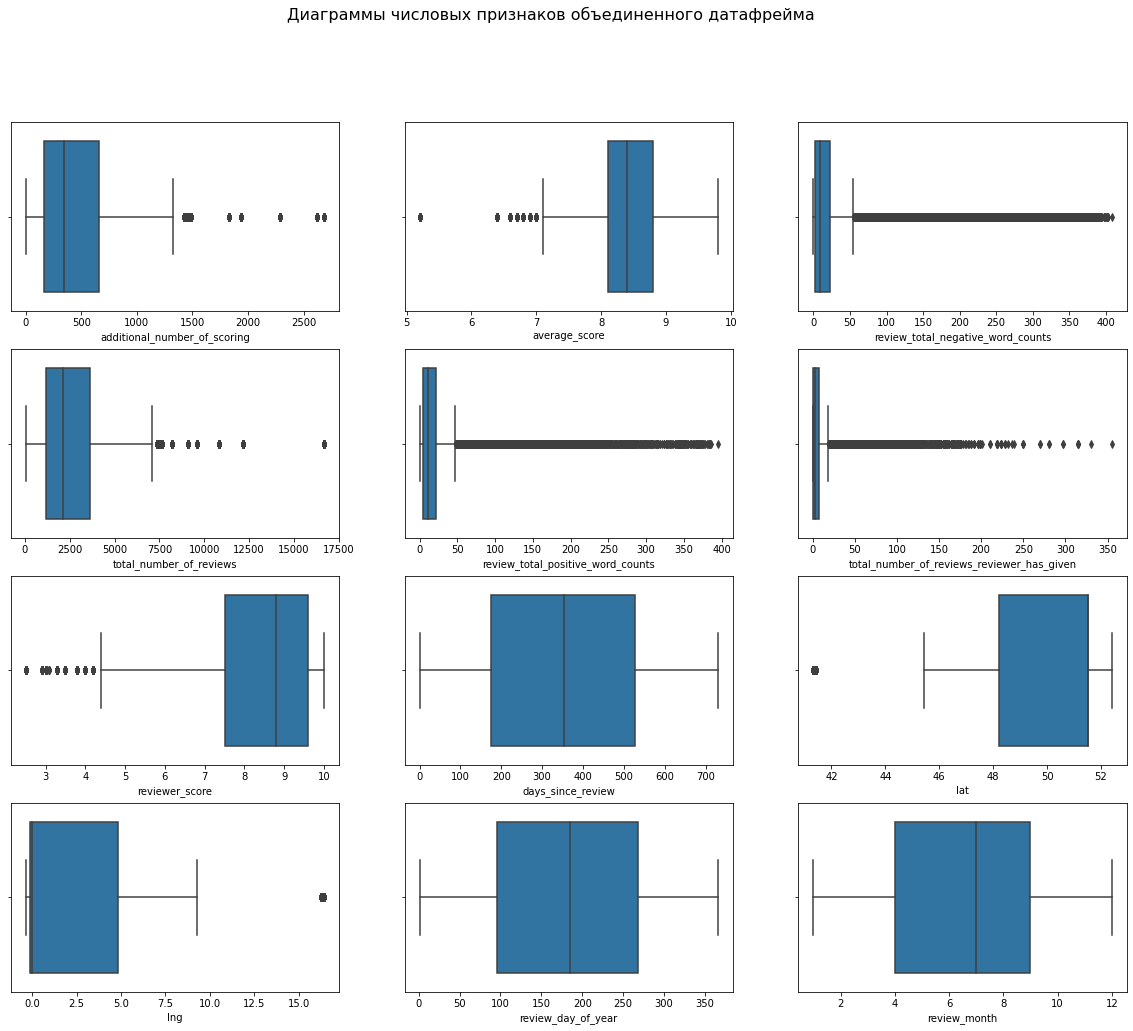

In [21]:
# Построим коробчатые диаграммы числовых признаков для обнаружения аномалий
ncols = 3 # кол-во столбцов для расположения графиков
nrows = int(round(len(num_cols) / ncols, 0)) # кол-во рядом для графиков

# Построим графики
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4*nrows))
for i, feat in enumerate(num_cols):
    if feat == 'reviewer_score': # если признак - оценка путешественника, то используем тренировочный датафрейм, т.к. ...
        sns.boxplot(data=df_train, x=feat, ax=axes[divmod(i,ncols)]); #... в объединенном присутствуют нулевые значения из тестового датафрейма
    else:
        sns.boxplot(data=joined_df, x=feat, ax=axes[divmod(i,ncols)]);
fig.suptitle("Диаграммы числовых признаков объединенного датафрейма", fontsize=16);

**Выводы по работе с выбросами:**  
<u>Значения, похожие на аномалии:</u>  
- В признаке **additional_number_of_scoring** (дополнительные оценки без отзывов и без проверки) стоит обратить внимание на значения свыше 1500. Таким высоким показателем отличаются 5 отелей. Их список приведен в ячейке ниже.  
- "Лидером" по аномально высокому количеству проверенных отзывов (признак **total_number_of_reviews**) стал итальянский отель 'Hotel Da Vinci'.  Список отелей с числом отзывов свыше 7500 приведен в ячейке ниже. Отметим, что по данному и предыдущему признаку (которые непосредственно влияют на рейтинг отеля) часто встречающимися являются следующие три отеля:  
    - Britannia International Hotel Canary Wharf,
    - Strand Palace Hotel,  
    - Park Plaza Westminster Bridge London.  
    Нельзя утверждать, что эти оценки и отзывы ненастоящие или что в датафрейме содержатся ошибки, но на эти отели стоит обратить пристальное внимание: либо они и правда столь популярны, отчего и получают огромное количество отзывов и оценок, либо они стремятся искуственно завысить свой рейтинг.  
- В антирейтинге аномальных значений признака **reviewer_score** (ниже 4.3) лидирует лондонский 'Britannia International Hotel Canary Wharf'. Он также входит и в предыдущие два признака. Это может свидетельствовать о том, что отель предлагает низкокачественный сервис, и путешественники охотно оставляют большое количество негативных отзывов и оценок. Либо отель стремится компенсировать реальный низкий рейтинг, самостоятельно размещая фейковые оценки и отзывы, что и приводит к их большому количеству. Примечательно, что по значению оценки рецензента свыше 9.0 в ТОП попали известные нам уже 'Park Plaza Westminster Bridge London' и 'Strand Palace Hotel' (их пересечения с двумя предыдущими признаками приведено в ячейке ниже). Тут также возможен дуализм: большое количество реальных положительных отзывов отражает высокий рейтинг отеля, либо отелям удалось искусственно поднять свой рейтинг, размещая фейковые отзывы и оценки. (Примечание: диаграмма данного признака построена только на тренировочном датафрейме.)    

<u>Значения, не являющиеся аномалиями:</u>  
- По низкому значеню признака **average_score** выделяется отель 'Hotel Liberty' в Италии: его средний рейтинг - 5.2. В объединенном датафрейме содержатся 65 записей об этом отеле, а среднее значение, которое рецензенты поставили этому отелю в тренировочном датафрейме (признак reviewer_score), равно 5.1, так что признать это аномалией было бы неверно.  
- В признаках **review_total_negative_word_counts** и **review_total_positive_word_counts** (количество слов в негативных и позитивных отзывах) вряд ли можно выделить аномалии, поскольку отзывы индивидуальных, и некоторые путешественники могут действительно оставлять развернутые комментарии с целью повысить свой рейтинг на платформе или просто помочь другим путешественникам. 
- По такой же логике невозможно выделить аномалии в количестве отзывов, оставленных одним рецензентом (признак **total_number_of_reviews_reviewer_has_given**): люди могут часто путешествовать по работе или иметь своей работой оставлять отзывы на отели.  
- Значения широты (признак **lat**) меньше 42 не являются аномалиями, потому что соответствуют координатам отелей в Испании, которая по отношению к другим странам из датафрейма расположена ближе к экватору. Остальные же страны сгруппированы севернее.
- Также не являются аномалиями и значения долготы (признак **lng**) больше 15, т.к. принадлежат координатам отелей в Австрии, которая расположена восточнее других стран датафрейма по отношению к нулевому меридиану.  
- Признак **days_since_review** ничем не примечателен, за исключением того, что, как правило, "возраст" отзывов составляет 350 дней.  
- Наконец, из признаков **review_day_of_year** и **review_month** мы можем заключить, что путешественники оставляют отзывы в основом с апреля по сентябрь и чаще всего - в июле.  

Несмотря на то, что в некоторых признаках мы обнаружили аномальные значения, которые вызывают недоверие и позволяют предполагать, что указанные отели могут заниматься накруткой рейтинга, тем не менее, ни одно из значений не выходит за рамки допустимого или разумного (как, например, возраст соискателя работы свыше 100 лет, или количество жилых помещений в квартире, равное нулю). Таким образом, по итогу проверки на аномальность, мы не будем удалять никакие строки и столбцы из датафрейма, а значит и прибегать к использованию метода межквартильного размаха (метод Тьюки) или методу Z-отклонений для точного определения выбросов, нет необходимости.  
 

In [22]:
display('Отели с подозрительно большим количеством оценок без отзывов:',
      joined_df[joined_df['additional_number_of_scoring'] > 2000]['hotel_name'].value_counts())

'Отели с подозрительно большим количеством оценок без отзывов:'

Britannia International Hotel Canary Wharf    4789
Strand Palace Hotel                           4256
Park Plaza Westminster Bridge London          4169
Name: hotel_name, dtype: int64

In [23]:
display('Отели с подозрительно большим количеством отзывов:',
        joined_df[joined_df['total_number_of_reviews'] > 7500]['hotel_name'].value_counts().nlargest(4))

'Отели с подозрительно большим количеством отзывов:'

Britannia International Hotel Canary Wharf    4789
Strand Palace Hotel                           4256
Park Plaza Westminster Bridge London          4169
Hotel Da Vinci                                1876
Name: hotel_name, dtype: int64

In [24]:
# Посмотрим, какие отели имеют аномальные значения признаков и высокий рейтинг
s1 = set(joined_df[joined_df['reviewer_score'] > 9]['hotel_name'].value_counts().head(10).index)
s2 = set(joined_df[joined_df['total_number_of_reviews'] > 7500]['hotel_name'].value_counts().index)
s3 = set(joined_df[joined_df['additional_number_of_scoring'] > 1500]['hotel_name'].value_counts().index)

# Пересечем все три множества
display('Отели с рейтингом выше 9.0 и с аномально большим кол-вом оценок и отзывов:',
    s1.intersection(s2.intersection(s3)))

'Отели с рейтингом выше 9.0 и с аномально большим кол-вом оценок и отзывов:'

{'Park Plaza Westminster Bridge London', 'Strand Palace Hotel'}

___

# 3. Разведывательный анализ данных.  
**Подэтапы:**  
3.1. Проектирование признаков.   
3.2. Кодирование признаков.  
3.3. Преобразование признаков: нормализация и стандартизация.  
3.4. Оценка мультиколлинеарности признаков.    
3.5. Оценка значимости признаков и отбор.  

## 3.1. Проектирование признаков:  
- Страна и город отеля  
- Расположение отеля в столице и вблизи моря  
- Удаленность отеля от центра города  
- Совпадение страны отеля со страной путешественника  
- Количество проведенных ночей в отеле  
- Эмоциональная окраска отзывов

### Проектирование признаков страны и города, где расположены отели.  
Начнем с того, что выясним, в каких странах и городах расположены отели.

In [25]:
# Создадим функцию, выделяющую страну и город из адреса отеля
def sep_count_city(ds:pd.Series) -> dict:
    """Функция выделяет из принакана адреса
    страну и город расположения отеля.

    Args:
        ds (pd.Series): столбец с адресами отелей

    Returns:
        dict: словарь с названиями стран и городов
    """

    countries = {}
    for row in ds:
        country = row.split()[-1] # последнее слово в каждом адресе - страна
        if country == 'Kingdom': # в случае в Великобританией, слова два,
            country = 'United Kingdom' # поэтому исправим это
            city = row.split()[-5] # и название города стоит 5-м с конца
        else:
            city = row.split()[-2] # а для остальных стран - 2-м с конца
        
        if country in countries.keys(): # если страна уже в словаре...
            if city not in countries[country]: # а город - нет,
                countries[country].append(city) # добавим город к стране
        else:
            countries[country] = [city] # иначе добавим новую страну с городом
    
    # Вернем словарь стран и городов
    return countries

# Обработаем признак адреса с помощью функции и выведем результат
count_city = sep_count_city(joined_df['hotel_address'])
display('Страны и города, в которых расположены отели:', count_city)

'Страны и города, в которых расположены отели:'

{'United Kingdom': ['London'],
 'France': ['Paris'],
 'Netherlands': ['Amsterdam'],
 'Italy': ['Milan'],
 'Austria': ['Vienna'],
 'Spain': ['Barcelona']}

Итак, все отели в датафрейме расположены всего в 6 странах, и в каждой стране - лишь в одном городе. Создадим признаки страны и города отеля.

In [26]:
# Создаем признак страны отеля
joined_df['hotel_country'] = joined_df['hotel_address']\
    .apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else 'United Kingdom')

# Сперва "изменим" ключ словаря для упрощения заполнения городов
count_city['Kingdom'] = count_city.pop('United Kingdom')
# Создаем признак города отеля
joined_df['hotel_city'] = joined_df['hotel_address'].apply(lambda x: count_city[x.split()[-1]][0])

# Вернем ключ словаря к исходному состоянию для последущего использования
count_city['United Kingdom'] = count_city.pop('Kingdom')

Посмотрим на распределение отелей в датафрейме по городам.  

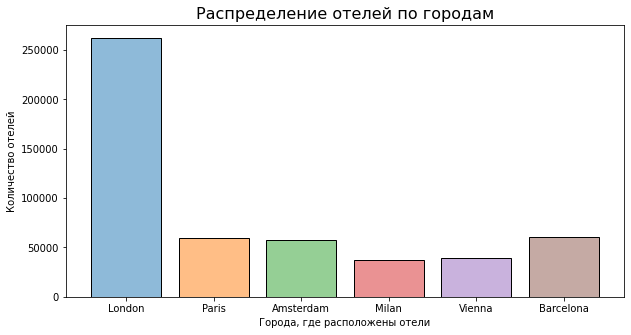

In [27]:
# Построим график распределения отелей по городам
fig = plt.figure(figsize=(10, 5))

histplot = sns.histplot(
    data = joined_df,
    x = 'hotel_city',
    hue = 'hotel_city',
    shrink = 0.8,
    legend = False
)
histplot.set_title('Распределение отелей по городам', fontsize=16);
histplot.set_xlabel('Города, где расположены отели');
histplot.set_ylabel('Количество отелей');

Как видно на гистограмме, подавляющее большинство отелей находятся в Лондоне. Учтем это в дальнейшей работе.  
Тут же было бы интересно посмотреть, из каких стран едут путешественники. Однако национальностей так много, что без дополнительной обработки этого признака, диаграмма будет неинформативна. Поэтому мы вернемся к этому вопросу позже.  

Теперь мы можем закончить этап очистки данных и заполнить пустые значения в признаках lat и lng медианным значением, характерным для каждого из городов (или стран). Мода тут вряд ли подойдет, т.к. в этом случае географические координаты отелей будут совпадать, и отель с худшим рейтингом может оказывать влияние на отель с лучшим рейтингом (и наоборот).

In [28]:
# Создадим массив из названий городов, где пропущены значения в столбце lat (или lng, т.к. это одни и те же строки)
no_geo_cities = joined_df[joined_df['lat'].isnull()]['hotel_city'].unique()

# В цикле пройдемся по этим городам (их всего три)
for city in no_geo_cities:
    # Сделаем срез датафрейма по городу, пропускам и сохраним индексы таких строк
    mask1 = joined_df['hotel_city'] == city
    mask2 = joined_df['lat'].isnull() == True
    ind = list(joined_df[mask1 & mask2].index)
    
    # По индексам заменим пропущенные значения в столбцах на медиану, характерную для каждого из городов
    joined_df.loc[ind, 'lat'] = joined_df[mask1]['lat'].median()
    joined_df.loc[ind, 'lng'] = joined_df[mask1]['lng'].median()

# Проверим результат выполнения кода
print('Количество оставшихся пропусков во всем датафрейме:', joined_df.isnull().any().sum())

Количество оставшихся пропусков во всем датафрейме: 0


### Проектирование признака расположения отеля в столице страны или рядом с морем  
Мы выяснили, что отели из датафрейма расположены в 6 городах, два из которых не являются столицами своих государств: Барселона и Милан. Подчас столицы могут предложить большее разнообразие и более высокий уровень отдыха, чем регионы. Введем такой признак, а на этапе отбора проверим, справедливо ли наше предположение.

Также мы узнали, что два из шести городов имеют выход к морю и пляжи: Барселона и Амстердам. Отели на берегу моря можно отнести к классу курортных, противопоставляя их городским отелям (где, очевидно, предпочтение отдается осмотру достопримечательностей). Однако и Барселона и Амстердам не являются в чистом смысле курортными городами. Тем не менее, наличие пляжей может оказать влияние на впечателения и оценки путешественников. Поэтому добавим признак близости к морю.

In [29]:
# Создадим список столиц из всех городов, которые упоминаются в датафрейме
capitals = list(joined_df['hotel_city'].unique())
capitals.remove('Milan')
capitals.remove('Barcelona')

# Создадим признак нахождения отеля в столице
joined_df['is_capital'] = joined_df['hotel_city'].apply(lambda x: 1 if x in capitals else 0)

# Созданим признак нахождения отеля в городе рядом с морем (возможность купаться и загорать)
joined_df['is_on_sea'] = joined_df['hotel_city'].apply(lambda x: 1 if x in ['Amsterdam', 'Barcelona'] else 0)

### Проектирование признака удаления отеля от центра города  
Воспользуемся готовой базой данных по всем городам в мире на Kaggle: https://www.kaggle.com/datasets/juanmah/world-cities  

- Сначала прочитаем файл и сохраним в словарь координаты городов, упоминаемых в нашем проекте.  
- Затем преобразуем словать в датафрейм и добавим к нашему объединенному датафрейму в качестве промежуточного шага.  
- Наконец, с помощью написанной функции рассчитаем расстояния от отелей до центра городов и добавим их в наш датафрейм.  

In [30]:
# Загрузим датасет с данными о городах
df_cities = pd.read_csv(CITIES_DIR+'/worldcities.csv')

# Создадим словать с координатами нужных городов
city_centers = {}

# Пройдемся в цикле по интересующим нас городам и сохраним их координаты
for country, city in count_city.items():
    mask1 = df_cities['country'] == country
    mask2 = df_cities['city'] == city[0]
    lat = df_cities[mask1 & mask2]['lat'].values[0]
    lng = df_cities[mask1 & mask2]['lng'].values[0]
    city_centers[city[0]] = [lat, lng]

# Проверим, что это шаг удался
display('Словарь с координатами городов:',city_centers)

'Словарь с координатами городов:'

{'Paris': [48.8566, 2.3522],
 'Amsterdam': [52.3667, 4.8833],
 'Milan': [45.4669, 9.19],
 'Vienna': [48.2083, 16.3725],
 'Barcelona': [41.3825, 2.1769],
 'London': [51.5072, -0.1275]}

In [31]:
# Преобразуем словарь в датафрейм
city_centers_df = pd.DataFrame(city_centers, index=['city_lat', 'city_lng']).T
city_centers_df['hotel_city'] = city_centers_df.index
city_centers_df.reset_index(drop=True, inplace=True)

# Объединим основной и новый датафреймы по признаку города, в котором находится отель
joined_df = pd.merge(
    joined_df,
    city_centers_df,
    how='left',
    on='hotel_city'
)

# Удалим промежуточный датафрейм и словарь
del city_centers_df, city_centers

# Проверим этот шаг
display('Координаты центров городов добавлены в датафрейм:',
       joined_df[['hotel_city', 'lat', 'lng', 'city_lat', 'city_lng']].sample(2))

'Координаты центров городов добавлены в датафрейм:'

,hotel_city,lat,lng,city_lat,city_lng
374723,Paris,48.886687,2.344933,48.8566,2.3522
423904,London,51.492627,-0.228860,51.5072,-0.1275


In [32]:
# Подготовим функцию для рассчета расстояния от отеля до центра города
def dist_from_center(df:pd.DataFrame) -> pd.Series:
    """Функция по формуле гаверсинуса, найденной в интернете,
    вычисляет расстояние между двумя точками на поверхности
    Земли - местоположением отеля и центром города, в котором
    находится отель.
    Формула гаверсинуса изменена для того, чтобы производить
    вычисления на объектах Series.

    Args:
        df (pd.DataFrame): датафрейм с координатами

    Returns:
        pd.Series: признак расстояния между отелем и центром в км
    """
    
    r = 6371 # радиус Земли в километрах
    
    #  Преобразуем градусы в радианы
    lat1 = df['lat'].apply(radians)
    lng1 = df['lng'].apply(radians)
    lat2 = df['city_lat'].apply(radians)
    lng2 = df['city_lng'].apply(radians)
    
    # Формула гаверсинуса
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    
    # Часть формулы ниже преобразуем для Series
    #a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
    arg1 = (dlat / 2).apply(sin)
    arg1 = arg1**2
    
    arg2 = lat1.apply(cos)
    arg3 = lat2.apply(cos)
    
    arg4 = (dlon / 2).apply(sin)
    arg4 = arg4**2
    
    a = arg1 + arg2 * arg3 * arg4
    
    # Еще одну часть формулы тоже преобразуем для Series
    #c = 2 * asin(sqrt(a))
    a = a.apply(sqrt)
    c = a.apply(asin) * 2
    
    # Получим произведение Series на радиус Земли, округленное до 2 знаков
    result = round((c*r),2)
    
    # Очистим память от ненужных переменных
    del lat1, lat2, lng1, lng2, dlon, dlat, arg1, arg2, arg3, arg4, a, c, r
    
    # Вернем признак расстояний от отеля до центра города
    return result

In [33]:
%%time
# Вычислим расстояния от отеля до центра города и сохраним в промежуточный объект Series
distance = joined_df.groupby('hotel_name').apply(dist_from_center)

# Присвоим имя объекту Series - так будет называться признак в итоговом датафрейме
distance.name = 'km_from_center' 

# Избавимся от мультииндекса и удалим столбец с названием отеля, чтобы он не дублировался
distance = distance.reset_index(level=[0]).drop('hotel_name', axis=1)

# Добавим новый признак в датафрейм
joined_df = joined_df.merge(distance, left_index=True, right_index=True)

CPU times: user 7.36 s, sys: 49.3 ms, total: 7.41 s
Wall time: 7.41 s


Проверим результат работы и отобразим на графике средние расстояния по городам.

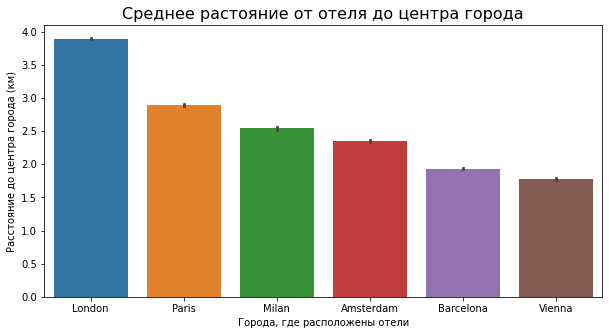

In [34]:
# Зададим порядок отображения городов в зависимости от расстояния до центра по убыванию
order = list(joined_df.groupby('hotel_city')['km_from_center'].mean().sort_values(ascending=False).index)

# Построим график
fig = plt.figure(figsize=(10, 5))
barplot = sns.barplot(
    data = joined_df,
    y = 'km_from_center',
    x = 'hotel_city',
    order = order
)
barplot.set_title('Среднее расстояние от отеля до центра города', fontsize=16);
barplot.set_xlabel('Города, где расположены отели');
barplot.set_ylabel('Расстояние до центра города (км)');

Самое большое расстояние до центра города приходится преодолевать туристам в Лондоне, самое маленькое - в Вене. Означает ли это, что наиболее удаленные отели обязательно получат оценку ниже, чем расположенные в центре? Совсем не обязательно. Во-первых, при наличии развитой сети общественного транспорта добраться до центра города можно довольно быстро, при этом сильно экономя на стоимости отеля. Во-вторых, выбирая отели, люди отдают себе отчет, что для них важнее. Поэтому даже трехзвездный отель может получить высокую оценку, если он предоставляет ожидаемый уровень сервиса за свои деньги, нежели пятизвездный, где забыли поменять постельное белье или рядом с которым вдруг началась стройка.  

### Проектирование признака совпадения гражданства путешественника со страной отеля   
Возможно, что жители страны, в которой находится отель, более склонны ставить высокие оценки, чтобы поддержать отечественную туристическую индустрию, либо наоброт занижать оценки, чтобы стимулировать развитие. Это может оказаться важно, тем более, что большое количество отелей в нашем датафрейме расположены в одной стране - Великобритании.    
Создадим соответствующий признак, где 1 будет означать, что страна, откуда путешественник родом, совпадает со страной отеля, и 0 - в обратном случае.  

In [35]:
# Очистим признак страны путешественника от лишних пробелов по краям 
joined_df['reviewer_nationality'] = joined_df['reviewer_nationality'].apply(lambda x: x.strip())

# Создадим новый признак совпадения со страной отеля
f = lambda x, y: 1 if x == y else 0 # определяем функцию сравнения
joined_df['is_hotel_nation_match'] = joined_df[['reviewer_nationality', 'hotel_country']].apply(lambda x: f(*x), axis=1) # применяем ее к двум столбцам

### Проектирование признака количества ночей в отеле  
В некоторых отзывах среди тегов присутствует тег с количеством ночей, проведенных в отеле, который выглядит как: 'Stayed X nights'. Выделим это количество в новый признак. При отсутствии тэга укажем распространенное значение (моду).

In [36]:
p = re.compile(r"Stayed ([0-9])") # создаем шаблон текста для поиска
night_list = [] # список для хранения кол-ва ночей

# Запускаем цикл по всем тегам
for tag in joined_df['tags']:
    m = p.findall(tag) # найденное кол-во ночей сохраняем в переменной в виде списка
    if len(m) == 1: # если в тегах был найден шаблон и кол-во ночей, ...
        night_list.append(int(m[0])) # то добавляем в список
    else: # если же в тегах не указано кол-во ночей, и список пустой, ...
        night_list.append(np.NaN) # заполним пустым значением
joined_df['nights_stayed'] = pd.Series(night_list) # добавим признак кол-ва ночей в датафрейм

print('Количество пропусков в признаке количества ночей в отеле:', joined_df['nights_stayed'].isna().sum())
print('Мода признака:', int(joined_df['nights_stayed'].mode()[0]), 'ночь')

# Заполним пропуски модой и приведем признак к целочисленному типу
joined_df['nights_stayed'].fillna(joined_df['nights_stayed'].mode()[0], inplace=True)
joined_df['nights_stayed'] = joined_df['nights_stayed'].astype('int')

# Проверим результат работы
print('Количество оставшихся пропусков в признаке после заполнения модой:', joined_df['nights_stayed'].isna().sum())

Количество пропусков в признаке количества ночей в отеле: 192
Мода признака: 1 ночь
Количество оставшихся пропусков в признаке после заполнения модой: 0


### Проектирование признака эмоциональной окраски отзывов  
С помощью библиотеки `nltk` оцифруем отзывы путешественников. Инструмент возвращает долю негативных, нейтральных и положительных эмоций в отзыве, а также их совокупную оценку. Выделим эти четыре компонента из положительных и отрицательных отзывов, создав таким образом 8 новых признаков.  

In [37]:
# Загружаем файл со словами для оценки окраски и создаем анализатор текста
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
# Подготовим функцию для анализа эмоциональной окраски отзывов
def sentiment_breakdown(ds:pd.Series) -> pd.DataFrame:
    """Функция с помощью библиотеки ntlk проводит анализ
    отзывов рецензентов и возвращает числовые представления
    эмоциональных составляющих отзывов: отрицательной,
    нейтральной, положительной и совокупной.
    Результат возвращается в виде датафрейма.

    Args:
        ds (pd.Series): признак с отзывами

    Returns:
        pd.DataFrame: датафрейм с числовыми характеристиками
    """
    
    # Создадим словарь для хранения числовых составляющих
    prefix = ds.name + '_'
    res = {prefix+'neg': [],
           prefix+'neu': [],
           prefix+'pos': [],
           prefix+'compound': []}
    
    # В цикле пройдем по всем строкам признака и проанализируем каждый отзыв
    for row in ds:
        score = sent_analyzer.polarity_scores(row)
        for key, value in score.items():
            res[prefix+key].append(value)
    
    # Вернем датафрейм с новыми признаками
    return pd.DataFrame(res)

In [39]:
%%time
# С помощью написанной выше функции проведем анализ положительных и негативных отзывов
pos_sentiments = sentiment_breakdown(joined_df['positive_review'])
neg_sentiments = sentiment_breakdown(joined_df['negative_review'])

# Добавим новые признакми в объединенный датафрейм
joined_df = joined_df.join([pos_sentiments, neg_sentiments])

# Очистим память от промежуточных переменных
del pos_sentiments, neg_sentiments

CPU times: user 3min 53s, sys: 2.77 s, total: 3min 55s
Wall time: 3min 55s


## 3.2. Кодирование признаков.

### Понижение размерности признака национальности перед кодированием  
Эти действия можно было выполнить на этапе очистки данных, однако в тот момент мы не знали, в каких странах расположены отели. К тому же, проблема наиболее остро встала перед кодированием признака. Поэтому выполняем данные шаги здесь.  

In [40]:
# Получим доли национальностей путешественников в датафрейме
nations = round(joined_df['reviewer_nationality'].value_counts(normalize=True)*100, 2)
print(f'В датафрейме {nations.count()} различных национальностей путешественников.')

# Понизим размерность, объединив в список национальности с долей ниже 1%
nations_less_1 = list(nations[nations < 1].index)

# Исключим из списка страны, в которых расположены отели (это Austria с долей 0.47% и Spain - с 0.92%)
# (воспользуемся словарем со странами и городами отелей, который мы получили ранее)
for country in count_city.keys():
    if country in nations_less_1:
        nations_less_1.remove(country)

# Теперь эти национальности объединим под словом other в признаке reviewer_nationality
joined_df['reviewer_nationality'] = joined_df['reviewer_nationality'].apply(lambda x: 'other' if x in nations_less_1 else x)

В датафрейме 226 различных национальностей путешественников.


Для наглядности отобразим распределение на графике.

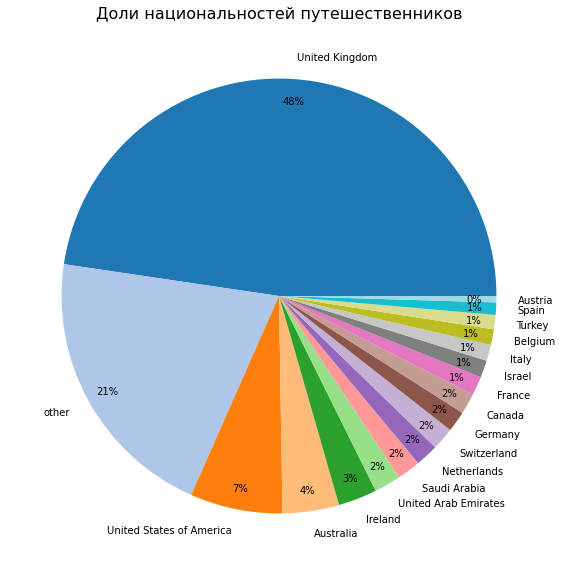

In [47]:
nat_pie = round(joined_df['reviewer_nationality'].value_counts(normalize=True).sort_values(ascending=False)*100,2)

# Постороим круговую диаграмму распределения национальностей путешественников
nat_pie.plot(
    kind = 'pie',
    figsize = (10,10),
    autopct = '%1.0f%%',
    pctdistance = 0.9,
    ylabel = '',
    colormap = 'tab20'
);
plt.title('Доли национальностей путешественников', fontsize=16);

Как и в случае с отелями, подавляющее большинство путешественников родом из Великобритании. Не удивительно, что наиболее часто встречающееся количество ночей, проведенных в отеле, равно одной ночи: видимо, такую долю формируют путешественники из Англии, посещающие английские отели. И можно предположить, что такая низкая продолжительность пребывания обусловливается бизнес-целями.

### Кодирование номинальных признаков
Перечислим признаки, требующие кодирования, и определим методы для их кодирования:  

| Название признака | Кол-во значений | Метод кодирования |
| - | - | - |
| hotel_country | 6 | Однократное кодирование |
| hotel_city | 6 | Однократное кодирование |
| reviewer_nationality | 18 | Двоичное кодирование |

In [48]:
feat_to_code = ['hotel_country', 'hotel_city'] # признаки для кодирования
cols_before = len(joined_df.columns) # кол-во признаков в датафрейме до кодирования

# Указываем столбцы для кодирования, настраиваем параметры
encoder = ce.OneHotEncoder(cols=feat_to_code, use_cat_names=True)
data_bin = encoder.fit_transform(joined_df[feat_to_code])

# Добавляем в датафрейм закодированные признаки
joined_df = pd.concat([joined_df, data_bin], axis=1)
cols_after = len(joined_df.columns) # кол-во признаков в датафрейме после кодирования

# Ввыводим результат работы
print(f'В результате кодирования добавлены {cols_after-cols_before} признаков.')

В результате кодирования добавлены 12 признаков.


In [49]:
feat_to_code = ['reviewer_nationality'] # признак для кодирования
cols_before = len(joined_df.columns) # кол-во признаков в датафрейме до кодирования

# Указываем столбцы для кодирования, настраиваем параметры
bin_encoder = ce.BinaryEncoder(cols=feat_to_code)
data_bin = bin_encoder.fit_transform(joined_df[feat_to_code])

# Добавляем в датафрейм закодированные признаки
joined_df = pd.concat([joined_df, data_bin], axis=1)
cols_after = len(joined_df.columns) # кол-во признаков в датафрейме после кодирования

# Выводим результат работы
print(f'В результате кодирования добавлены {cols_after-cols_before} признаков.')

В результате кодирования добавлены 5 признаков.


### Удаление строковых признаков и признака даты-времени

Итак, этапы очистки, проектирования и кодирования признаков завершены. На следующих подэтапах работа будет вестись только с числовыми типами данных, поэтому мы можем удалить все признаки типа object и datetime.

In [50]:
# Составим список признаков типа object и datetime
obj_cols = []
for col in joined_df.columns:
    if joined_df[col].dtype == 'object' or\
       joined_df[col].dtype == 'datetime64[ns]':
        obj_cols.append(col)

display(f'Следующие нечисловые признаки будут удалены ({len(obj_cols)}):', *obj_cols)
print('Кол-во признаков до удаления:', len(joined_df.columns))
joined_df.drop(obj_cols, axis=1, inplace=True)
print('Кол-во признаков после удаления:', len(joined_df.columns))

'Следующие нечисловые признаки будут удалены (9):'

'hotel_address'

'review_date'

'hotel_name'

'reviewer_nationality'

'negative_review'

'positive_review'

'tags'

'hotel_country'

'hotel_city'

Кол-во признаков до удаления: 54
Кол-во признаков после удаления: 45


## 3.3. Преобразование признаков.  
Для того, чтобы модель при обучении не делала преференций признакам с большими значениями (например, кол-во оценок или отзывов, исчисляемое тысячами) перед признакам с малыми (например, оценки сентиментальности отзывов, которые варьируются от 0 до 1), имеет смысл нормализовать датафрейм при помощи инструментов MinMaxScaler или RobustScaler. Кроме этого, полезным может быть стандартизация распределенных ненормально данных с помощью StandardScaler.  

Однако в результате экспериментов в рамках данного проекта было обнаружено, что два из трех методов (RobustScaler и StandardScaler) ухудшают итоговую оценку MAPE (в случае со стандартизацией - даже многократно!). А MinMaxScaler приводит к тому, что все предсказанные оценки оказываются меньше на порядок, из-за чего и от его использования также пришлось отказаться.  

В этой связи мы оставим здесь заготовленный код для всех методов, однако закомментируем его и не будем выполнять.

### Нормализация MinMaxScaler  
Не выполняется.

In [146]:
"""
# Составим список признаков для нормализации
col_names = list(joined_df.columns)

# Инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Кодируем исходный датафрейм
df_mm = mm_scaler.fit_transform(joined_df)

# Преобразуем промежуточный датафрейм в полноценный датафрейм для визуализации
joined_df = pd.DataFrame(df_mm, columns=col_names)
"""

'\n# Составим список признаков для нормализации\ncol_names = list(joined_df.columns)\n\n# Инициализируем нормализатор MinMaxScaler\nmm_scaler = preprocessing.MinMaxScaler()\n\n# Кодируем исходный датафрейм\ndf_mm = mm_scaler.fit_transform(joined_df)\n\n# Преобразуем промежуточный датафрейм в полноценный датафрейм для визуализации\njoined_df = pd.DataFrame(df_mm, columns=col_names)\n'

### Нормализация RobustScaler  
Не выполняется.

In [147]:
"""
# Составим список признаков для нормализации
col_names = list(joined_df.columns)

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(joined_df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
joined_df = pd.DataFrame(df_r, columns=col_names)
"""

'\n# Составим список признаков для нормализации\ncol_names = list(joined_df.columns)\n\n# инициализируем нормализатор RobustScaler\nr_scaler = preprocessing.RobustScaler()\n\n# кодируем исходный датасет\ndf_r = r_scaler.fit_transform(joined_df)\n\n# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации\njoined_df = pd.DataFrame(df_r, columns=col_names)\n'

### Стандартизация StandardScaler  
Не выполняется.

In [148]:
"""
# Составим список признаков, которые будем стандартизировать, кроме sample
col_names = list(joined_df.columns)
col_names.remove('sample')
sample = joined_df['sample']

# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
df_s = s_scaler.fit_transform(joined_df[col_names])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
joined_df = pd.DataFrame(df_s, columns=col_names)

#  Возвращаем сигнальный столбец тренировочной и тестовой выборки
joined_df = joined_df.join(sample)
"""

"\n# Составим список признаков, которые будем стандартизировать, кроме sample\ncol_names = list(joined_df.columns)\ncol_names.remove('sample')\nsample = joined_df['sample']\n\n# инициализируем стандартизатор StandardScaler\ns_scaler = preprocessing.StandardScaler()\n\n# кодируем исходный датасет\ndf_s = s_scaler.fit_transform(joined_df[col_names])\n\n# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации\njoined_df = pd.DataFrame(df_s, columns=col_names)\n\n#  Возвращаем сигнальный столбец тренировочной и тестовой выборки\njoined_df = joined_df.join(sample)\n"

## 3.4. Оценка мультиколлинеарности признаков.  
Используем корреляцию Пирсона, несмотря на то, что не все признаки в датафрейме распределены нормально, присутствуют выбросы и бинарные значения. Другие виды корреляций (Спирмена и Кендалла) демонстрируют похожие значения и приводят к тем же выводам.

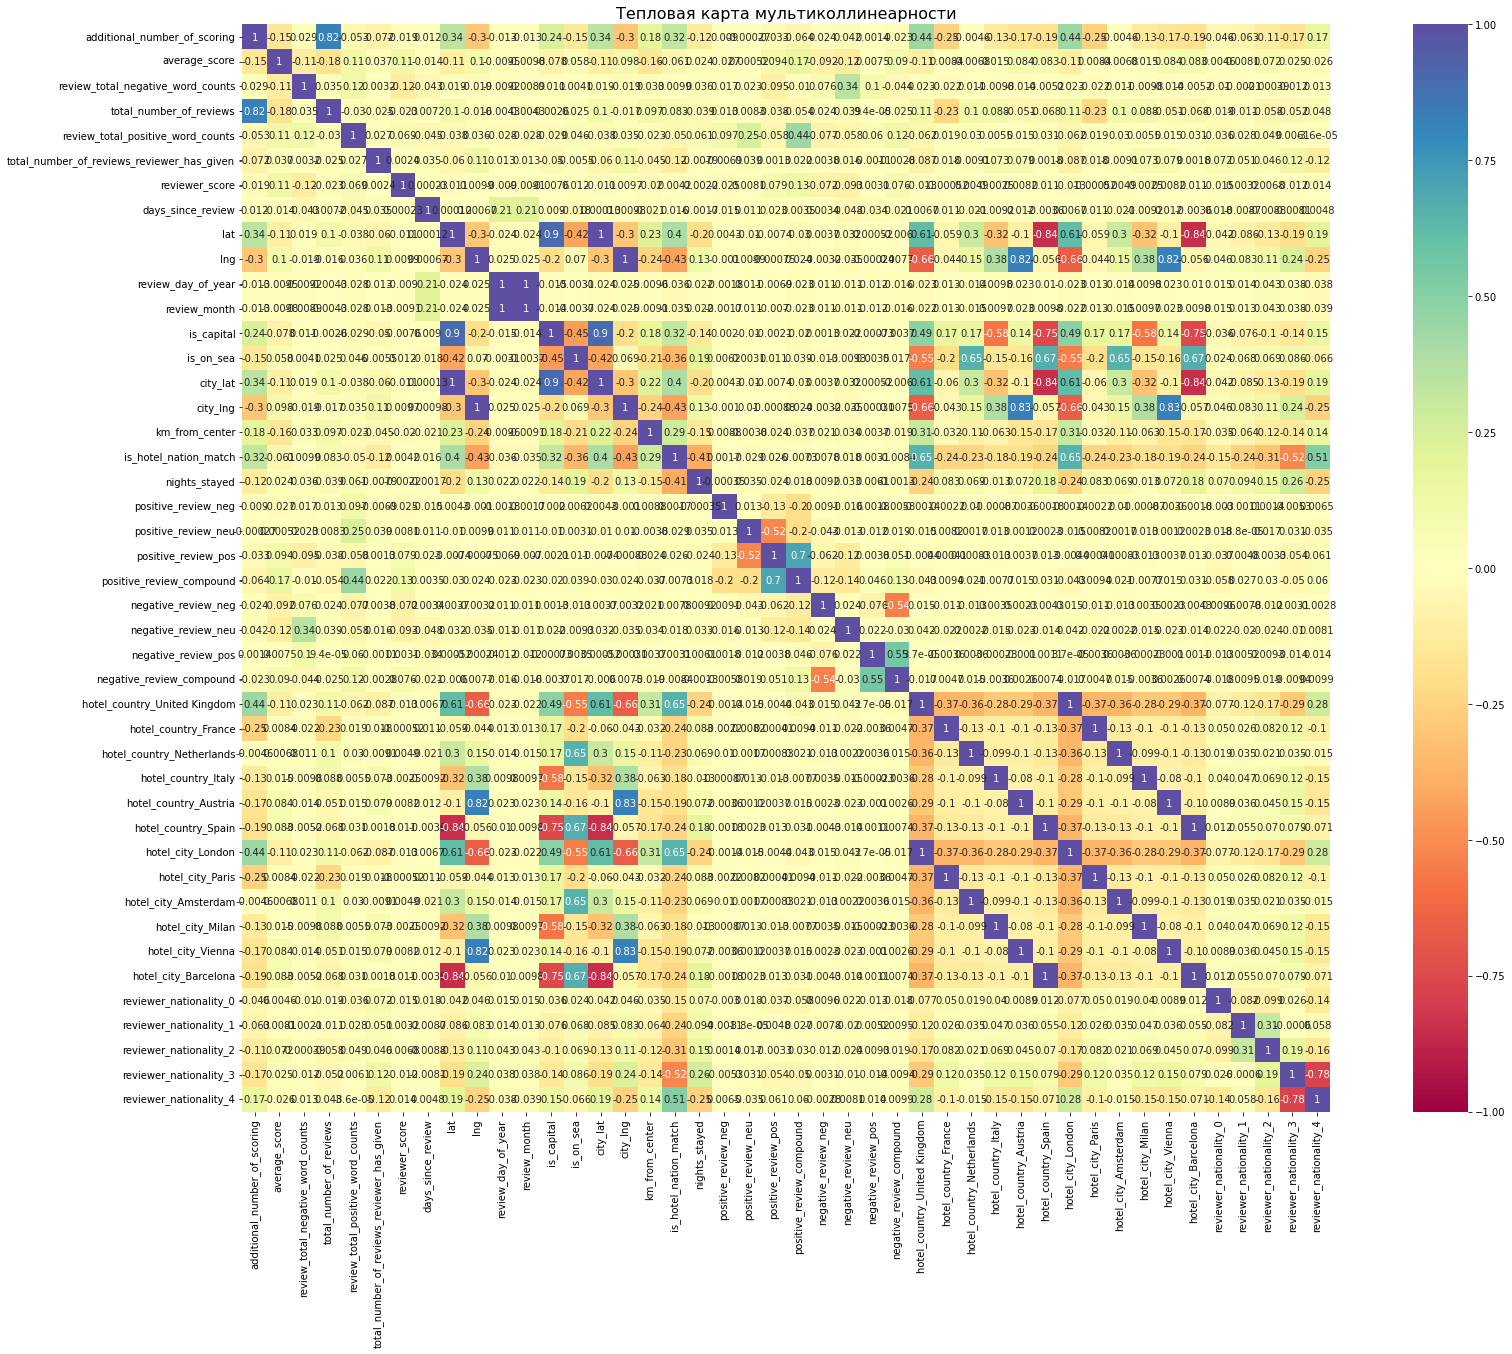

In [149]:
# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(
    joined_df.drop(['sample'], axis=1).corr(method='pearson'), # из датафрейма удалим сигнальный столбец
    annot = True, # отобразим значения в ячейках
    fmt = '.2g', # ограничим кол-во знаков после запятой двумя
    vmin = -1, # настроим мин., макс., и центральные значения легенды
    vmax = 1,
    center = 0,
    cmap= 'Spectral', # другие цветовые палитры - тут: https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
    #linewidths = 4, # установим толщину границ ячеек
    #linecolor = 'white', # установим цвет границ ячеек
    square = True # установим квадратный формат ячеек
)

heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=16);

1. Высокую корреляцию показывают сгенерированные в результате кодирования признаки города (hotel_city_London) и страны отеля (hotel_country_United Kingdom), а также признак столицы (is_capital) и промежуточные признаки с координатами центра города (city_lat, city_lng). Это наши первые кандидаты на удаление из датафрейма.    
2. Также сильную связь обнаруживает признак дополнительного числа оценок (additional_number_of_scoring) с количеством отзывов (total_number_of_reviews). Поскольку отзывов больше, чем простых оценок (1142 против 480), и поскольку большее доверие вызывают именно реальные проверенные отзывы, то предпочтительным оставить в датафрейме представляется признак total_number_of_reviews.  
3. Наконец, коррелируют между собой признаки месяца создания отзыва (review_month) и дня года (review_day_of_year).  
4. На грани высокой связи оказался признак курортного города (is_on_sea).  
5. Признаки reviewer_nationality 3 и 4 также выделяются, однако они является компонентами единого признака после бинарного кодирования, поэтому удалять их мы не станем.  

Составим предварительный список признаков для удаления и уточним его на следующем этапе отбора признаков:  
`del_cols = ['hotel_city_London', 'hotel_city_Paris', 'hotel_city_Amsterdam',
            'hotel_city_Milan', 'hotel_city_Vienna', 'hotel_city_Barcelona',
            'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands',
            'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain',
            'is_capital', 'city_lat', 'city_lng',
            'additional_number_of_scoring']`

## 3.5. Оценка значимости и отбор признаков.  
Для проведения тестов мы разделим датафрейм, а после окончания тестов вернемся к нему, чтобы удалить ненужные признаки, и вновь разделим итоговый датафрейм для последующего обучения модели.

In [150]:
# Разделим объединенный датафрейм на тренировочный и тестовый 
df_train = joined_df[joined_df['sample'] == 1].drop('sample', axis=1)
df_test = joined_df[joined_df['sample'] == 0].drop(['sample', 'reviewer_score'], axis=1)

In [151]:
X = df_train.drop('reviewer_score', axis=1)
y = df_train['reviewer_score']

In [152]:
# Создадим списки категориальных и числовых признаков
cat_cols = ['average_score', 'lat', 'lng', 'review_day_of_year', 'review_month',
            'is_capital', 'is_on_sea', 'is_hotel_nation_match',
            'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands',
            'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain',
            'hotel_city_London', 'hotel_city_Paris', 'hotel_city_Amsterdam',
            'hotel_city_Milan', 'hotel_city_Vienna', 'hotel_city_Barcelona',
            'reviewer_nationality_0', 'reviewer_nationality_1',
            'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4']

num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'days_since_review', 'nights_stayed', 'km_from_center',
            'positive_review_neg', 'positive_review_neu', 'positive_review_pos', 'positive_review_compound',
            'negative_review_neg', 'negative_review_neu', 'negative_review_pos', 'negative_review_compound']

### Тест хи-квадрат

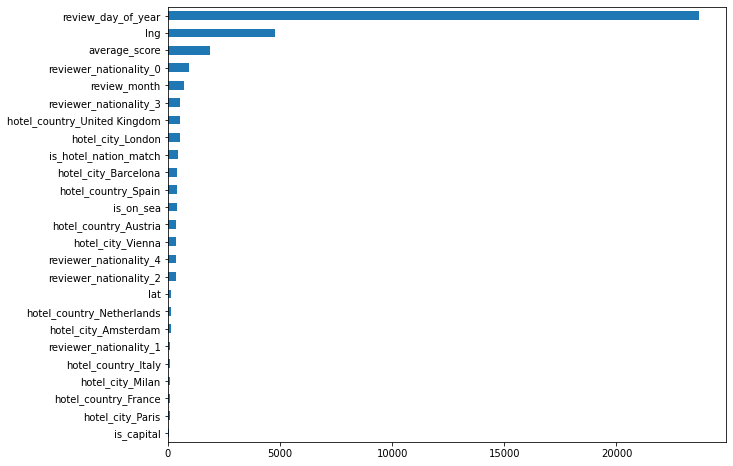

In [153]:
X['lng'] = X['lng'].apply(lambda x: abs(x)) # возьмем модуль долготы во избежании ошибки
y = y.astype('int') # "правильные ответы" приведем к типу int

fig = plt.figure(figsize=(10, 8))
# Воспользуемся тестом хи-квадрат из библиотеки sklearn.feature_selection
# для оценки значимости категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

1. По результатам хи-теста более значимым оказался признак review_day_of_year, поэтому принимаем решение об удалении review_month.  
2. Признак is_on_sea оказался малозначимым, поэтому от него тоже избавимся.

Список признаков для удаления теперь выглядит так:  
`del_cols = ['hotel_city_London', 'hotel_city_Paris', 'hotel_city_Amsterdam',
            'hotel_city_Milan', 'hotel_city_Vienna', 'hotel_city_Barcelona',
            'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands',
            'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain',
            'is_capital', 'city_lat', 'city_lng',
            'additional_number_of_scoring',
            'review_month', 'is_on_sea']`

### Тест ANOVA

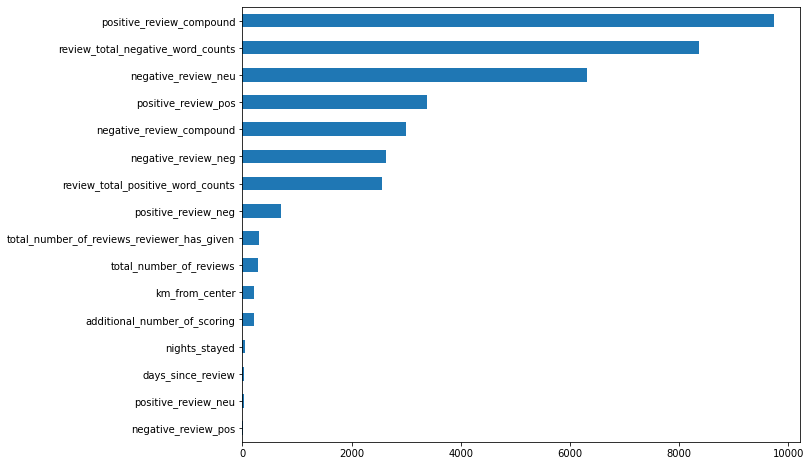

In [154]:
fig = plt.figure(figsize=(10, 8))
# Воспользуемся тестом ANOVA из библиотеки sklearn.feature_selection
# для оценки значимости непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Тест ANOVA продемонстрировал немного большую важность признака total_number_of_reviews над additional_number_of_scoring, тем самым утвердив наш выбор на удаление именно признака additional_number_of_scoring.

В итоге, наш список признаков для удаления имеет следующий вид:  
`del_cols = ['hotel_city_London', 'hotel_city_Paris', 'hotel_city_Amsterdam',
            'hotel_city_Milan', 'hotel_city_Vienna', 'hotel_city_Barcelona',
            'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands',
            'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain',
            'is_capital', 'city_lat', 'city_lng',
            'additional_number_of_scoring',
            'review_month', 'is_on_sea']`

Удалим нежужные признаки из исходного объединенного датафрейма, затем вновь разделим его и подготовим датасеты для подачи на вход модели.

In [155]:
# Список признаков для удаления
del_cols = ['hotel_city_London', 'hotel_city_Paris', 'hotel_city_Amsterdam',
            'hotel_city_Milan', 'hotel_city_Vienna', 'hotel_city_Barcelona',
            'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands',
            'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain',
            'is_capital', 'city_lat', 'city_lng',
            'additional_number_of_scoring',
            'review_month', 'is_on_sea']

# Удаляем признаки
print('Было признаков до удаления:', len(joined_df.columns))
joined_df.drop(del_cols, axis=1, inplace=True)
print('Стало после удаления:', len(joined_df.columns))

Было признаков до удаления: 45
Стало после удаления: 27


In [156]:
# Разделяем датафрейм и готовим для обучения модели
df_train = joined_df[joined_df['sample'] == 1].drop('sample', axis=1)
df_test = joined_df[joined_df['sample'] == 0].drop(['sample', 'reviewer_score'], axis=1)
X = df_train.drop('reviewer_score', axis=1)
y = df_train['reviewer_score']

**Выводы по разведовательному анализу:**  
1. Нами был спроектирован ряд признаков: из существовавших в исходном датафрейме, а также за счет внешнего источника. Однако не все из созданных признаков показали значительное влияние на оценку отеля рецензентом. И поскольку они демонстрировали высокую корреляцию с другими признаками, от них пришлось избавиться.  
2. Несмотря на это, сгенерированные признаки в особенности за счет их визуализации, позволили лучше понять состав датафрейма и сформулировать гипотезы. Стало очевидным, что на итоговую оценку рецензентом решающую роль играет его собственное впечатление от отеля и предоставляемых услуг, нежели от таких факторов, как близость к морю или город расположения отеля. Наиболее важными оказались признаки сентиментальной окраски отзывов путешественников.  
3. С учетом обнаруженного в пункте 2, не представляется интересным добавлять признаки ВВП страны отеля, количества жителей в городе или индекса Биг-Мака этой страны. А вот количество звезд отеля, а также спектр предоставляемых услуг, наверняка, оказали бы большое влияние на оценку. Однако API Booking.com предоставляется только официальным партнерам, а спарсить данные о полуторе тысяч отелей - задача крайне трудоемкая и по своему эффекту не соизмеримая с целями данного проекта, поэтому мы обозначим это как возможность для возможной реализации в других проектах.  
4. По той же причине мы не стали проводить дополнительного анализа исходной колонки tags, откуда можно было бы почерпнуть информацию о типе комнаты, виде поездки и даже составе семьи. Достаточно того, что полученные сведения о количестве проведенных ночей, позволили добиться искомого результата итоговой метрики MAPE. Разумеется, если бы оно не было достигнуто, мы бы провели этот дополнительный анализ тэгов.  
5. Наконец, забегая вперед, мы скажем, что методы нормализации и стандартизации, о которых шла речь на данном этапе, или почти не оказывают влияния на модель машинного обучения RandomForestRegressor, или оказывают даже негативное влияние с точки зрения итоговой метрики MAPE. Более того в результате нормализации с помощью MinMaxScaler все предсказываемые моделью оценки оказываются в 10 раз меньше положенного, то есть меньше нуля. Это можно исправить, умножая их на 10, но мы выбрали отказаться от нормализации с помощью данного метода при использовании RandomForestRegressor в качестве модели.  
___

# 4. Обучение модели и оценка результатов.  

### Разделение выборок

In [157]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [158]:
# Проверяем размерности датасетов
df_test.shape, df_train.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386496, 26), (386496, 25), (309196, 25), (77300, 25))

### Обучение модели

In [159]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [160]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


## Оценка результатов  

Несмотря на апдейт библиотеки с помощью команды `!pip install -U scikit-learn`, функция metrics.mean_absolute_percentage_error() все равно не хочется вызываться - возникает ошибка. Поэтому вычисляем значение MAPE с помощью собственной функции.

In [161]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются.
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mae = round(metrics.mean_absolute_error(y_test, y_pred), 4)
print(f'MAE: {mae}')

MAE: 0.8788


In [162]:
# Используем собственную функцию для вычисления MAPE
def mape_func(y_test, y_pred):
    mape = np.mean(np.abs((y_test-y_pred)/y_test))*100
    return mape

try:
    print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
except:
    mape = round(mape_func(y_test, y_pred), 4)
    print(f'Hand made MAPE: {mape} %')

Hand made MAPE: 12.5596 %


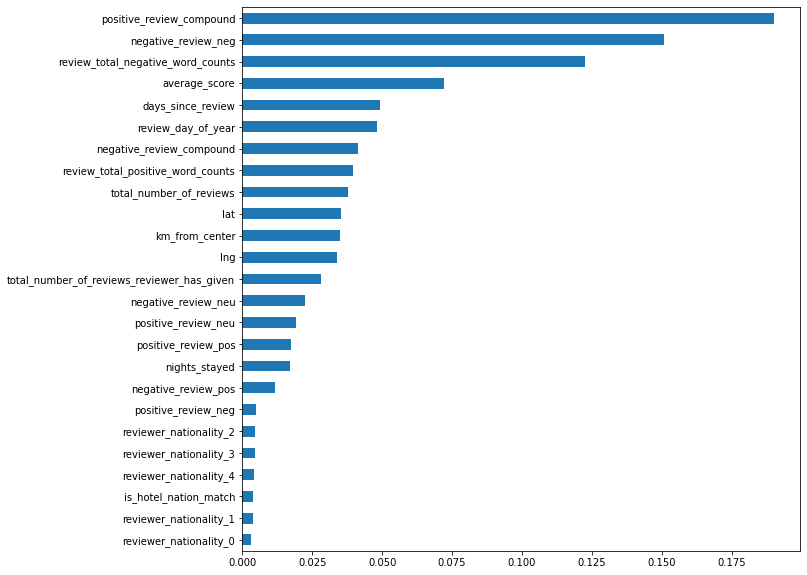

In [163]:
# Оценим важность признаков с т.зр. RandomForestRegressor
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh');

**Выводы по этапу обучения модели и оценке результатов:**  
1. В этом проекте мы не изучали устройство и принципы работы модели, а использовали ее как есть, даже без изменения параметров. Поэтому основной фокус мы сделали на подготовку и разведовательный анализ данных как на средства манипулирования итоговой метрикой.  
2. Проделанная работа позволила добиться значения MAPE на уровне 12,56%, что лучше целевой планки в 13,5%.  
3. Улучшение оценки путем отбора и подбора признаков проводилось вручную. Использование машинных алгоритмов поставим себе целью в последующих проектах.  
4. Интересно отметить, что наилучшее значение MAPE (12.54%) было достигнуто нами при неверном значении долготы центра Лондона: оно было взято по модулю.  
___

# 5. Предсказание рейтигов моделью и сохранение результатов в submission.csv  

In [164]:
display('Файл с результатами до обновления:', sample_submission)

'Файл с результатами до обновления:'

,reviewer_score,id
0,8.566,488440
1,7.462,274649
2,8.208,374688
3,9.703,404352
4,9.658,451596
...,...,...
128930,8.960,495812
128931,9.290,315577
128932,8.270,511968
128933,9.625,303386


In [165]:
# Получаем предсказание модели
predict_submission = model.predict(df_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [166]:
print('Предсказанные рейтинги:', predict_submission)

Предсказанные рейтинги: [8.684 7.607 8.305 ... 8.158 9.592 7.169]


При использовании MinMaxScaler рейтинги оказываются ниже на порядок. Это можно исправить следующим кодом:  
`predict_submission = predict_submission * 10`

In [168]:
# Сохраняем результаты предсказания рейтингов в файл с итогами
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [169]:
display('Файл с результатами после обновления:', sample_submission)

'Файл с результатами после обновления:'

,reviewer_score,id
0,8.684,488440
1,7.607,274649
2,8.305,374688
3,9.710,404352
4,9.662,451596
...,...,...
128930,8.915,495812
128931,9.334,315577
128932,8.158,511968
128933,9.592,303386


**Выводы по проекту:**  
1. Несмотря на кажущуюся простоту задачи (очистка данных и генерирование новых признаков за счет здравого смысла и известных инструментов библиотек python без изучения устройства модели машинного обучнения), проект оказался довольно трудоемким и сложным, и занял свыше 40 часов, включая время на изучение учебных материалов и просмотр вводного вебинара.  
2. С точки зрения оформления и визуализации он уступает предыдущим проектам, основной упор которых делался именно на эту составляющую. Впрочем, никто не ограничивал нас в использовании всего имеющегося арсенала приемов визуализации, однако поскольку основная задача была в том, чтобы обучить модель и добиться улучшения метрики MAPE, на это были брошены все силы. И с учетом затраченного времени, другим составляющим проекта пришлось уделить меньше внимания.  
3. Вместе с тем, данный проект показал значимость подготовки данных перед обучением модели и позволил потренировать полученные навыки разведывательного анализа.  
4. Особой ценностью данного проекта стоит отметить его реализацию на платформе kaggle в атмосфере здоровой конкуренции за высокий рейтинг. Вместе с предыдущим, бонусным проектом по предсказанию стоимости подержанных автомобилей, эти два проекта предоставили действительный инструмент повышения своих навыков Data Scientist'а и, следовательно, шансов на трудоустройство через участие в реальных интересных соревнованиях.  
___